# Exercise Sheet 5 - Variational Autoencoders

- Deep Learning for Computer Vision - Winter Term 2023/24
- Organizers: Anwai Archit, Sushmita Nair, Constantin Pape
- Tutors: Ahsan Ali, Anwai Archit, Lukas Friedrich, Piklu Mallick, Sushmita Nair, Ayush Paliwal
- Due date: **Tuesday**, Jan 16, before 10:00

In this exercise a variational autoencoder (VAE) shall be implemented and trained on the fashion MNIST dataset. VAEs are an example of generative deep learning and can be used to synthesize data - images in this case - which shall also be demonstrated in this exercise!

### IMPORTANT SUBMISSION INSTRUCTIONS

- **You need to answer all the questions in written form**
- When you're done, download the notebook and **rename** it to ```<surname1>_<surname2>_<surname3>.ipynb```
- Only submit the Jupyter Notebook (ipynb file). No other file is required. Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission of Homework 5`
- Make only one submission of the exercise per group.
- The deadline is strict
- You have to present the exercise in the tutorials. We have a high ratio of students to tutors, so please decide which team member presents which part beforehand.

### TASKS
* TASK 1: Implement a VAE
* TASK 2: Train the model and plot train and test set loss over training in the same plot
* TASK 3: Determine optimal dimensionality of latent space
* TASK 4: Plot some latent traversals
* TASK 5: Visualize class labels in latent space

## Setup and Requirements

### Imports

In [305]:
from __future__ import print_function
import pathlib

import matplotlib.pyplot as plt

import torch
import torch.utils.data

from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import torchvision.utils

import numpy as np

!nvcc --version
!python --version
print(torch.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
Python 3.10.12
2.0.0


In [306]:
from torchvision.utils import save_image

### Basic setup

Define various global parameters used throughout the notebook!

In [307]:
# Try to use GPU if available
use_cuda = True

# Path for data
data_dir = pathlib.Path('data/')

# Batch size
batch_size = 128

# Image size (same size in both dimensions)
image_size = 28

# Dimension of the latent space
latent_space_dim = 10

# Number of epochs to train
epochs = 5

# How many batches to skip before logging training status
log_interval = 100

# Exponential averaging factor for loss graphs
exp_average_factor = 0.90

# Define beta (weighting of regularization loss)
beta = 1

# Channels in the convolutional layers
capacity = 32

# Learning rate for the optimizer
learning_rate = 1e-3

# Define size / zoom level of plots
plot_zoom = 2
plot_w, plot_h = plt.figure().get_size_inches()
plot_w = plot_w * plot_zoom; plot_h = plot_h * plot_zoom;

<Figure size 640x480 with 0 Axes>

Test if a GPU (CUDA) is available in the environment and use it if it is. Otherwise use the CPU.

In [308]:
if use_cuda and not torch.cuda.is_available():
    print("Error: cuda requested but not available, will use cpu instead!")
    device = torch.device('cpu')
elif not use_cuda:
    print("Info: will use cpu!")
    device = torch.device('cpu')
else:
    print("Info: cuda requested and available, will use gpu!")
    device = torch.device('cuda')


Info: cuda requested and available, will use gpu!


## Get and preprocess the data


We will use the FashionMNIST data set from Zalando (https://github.com/zalandoresearch/fashion-mnist) for our experiments.  
From the quoted github-repo: "Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits."


### Load the data for training and testing

The FashionMNIST dataset is already included in the torchvision datasets with the approriate training and test splits. Run the cell below to use it in this notebook.

In [309]:

# Load the datasets
train_dataset = datasets.FashionMNIST('./data', train=True, download=True,
                            transform=transforms.ToTensor())
test_dataset = datasets.FashionMNIST('./data', train=False,
                           transform=transforms.ToTensor())



For comparison, you can also use the well known MNIST dataset, which is also already included in the torchvision datasets with the approriate training and test splits. Just run the cell included in the appendix instead if you want to use it in this notebook.

Define data loaders for the training and test sets which return batches of samples.

In [310]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size, shuffle=False)

### Plot the data

To get an impression of the dataset plot some random exemplary pictures.

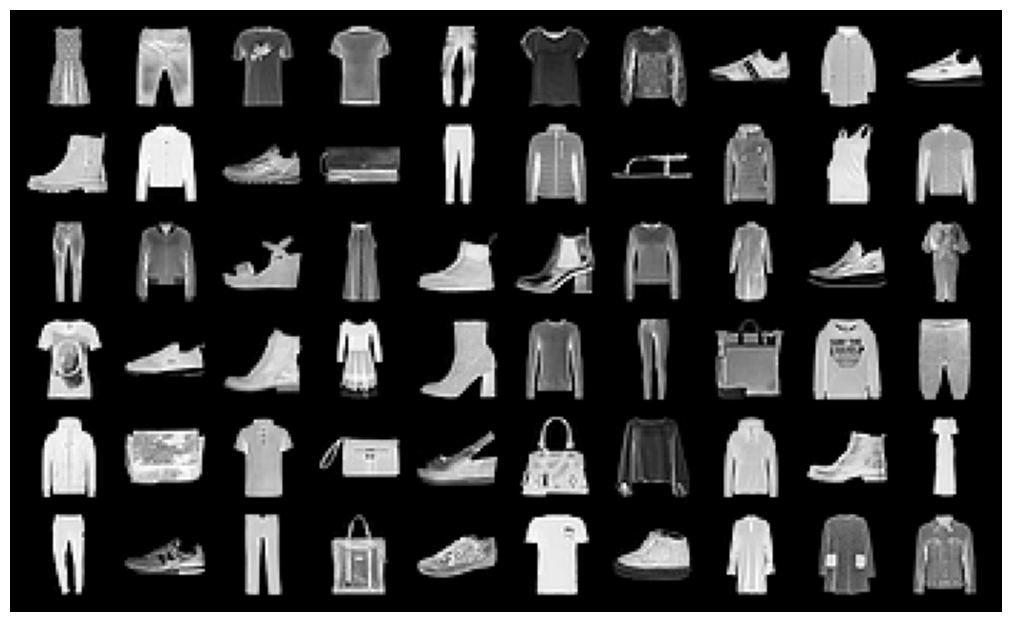

In [311]:
images_columns = 10
images_rows    = 6

def show_grid(images_tensor, images_columns, images_rows):
    image = torchvision.utils.make_grid(images_tensor, images_columns, images_rows)
    image = image.numpy()
    fig = plt.gcf()
    fig.set_size_inches(plot_w, plot_h)
    plt.axis('off')
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.show()

data_iterator = iter(train_loader)
images, labels = next(data_iterator)

show_grid(images[0:(images_columns * images_rows)], images_columns, images_rows)


## Implement a VAE neural network architecture

### Implement the network architecture

Recall that a VAE roughly consistst of two parts: The encoder (which reduces the number of dimensions and maps the input to the latent space) and the decoder (which reverses the encoding, mapping from the latent space back to the initial space).

In VAEs (compared to standard auto-encoders) we assume that the latent space is generated from a multi-variate normal distribution (N~(μ, σ²)) that is parameterized by two vectors, mean and variance. In the network, we use the log of the variance. 

In training, we sample from the distribution using the current values of the two vectors, which are updated in each step. After training, we use the mu value to draw the samples.

In a Variational Autoencoder (VAE), the latent space refers to the lower-dimensional space where the encoder maps input data, such as images, into a set of continuous-valued latent variables. The term "latent" implies that these variables are not directly observed in the training data but are inferred by the mode. The latent space is typically chosen to have a simple, regular distribution, such as a multivariate Gaussian distribution. The encoder network in a VAE takes an input sample and maps it to a distribution in the latent space, usually parameterized by a mean and a variance. The reparameterization trick is often used to sample from this distribution in a way that allows for backpropagation during training. During the training process, VAEs aim to make the distribution in the latent space match a chosen prior distribution (often a standard Gaussian distribution). This encourages the model to learn a meaningful and continuous representation of the input data in the latent space. The ability to sample from this latent space allows for generating new data by feeding random samples through the decoder network. The VAE architecture thus enables both encoding (mapping input data to the latent space) and decoding (generating new data from samples in the latent space). The latent space serves as a compact and structured representation of the input data, facilitating tasks such as data generation, interpolation, and exploration of the learned feature space.

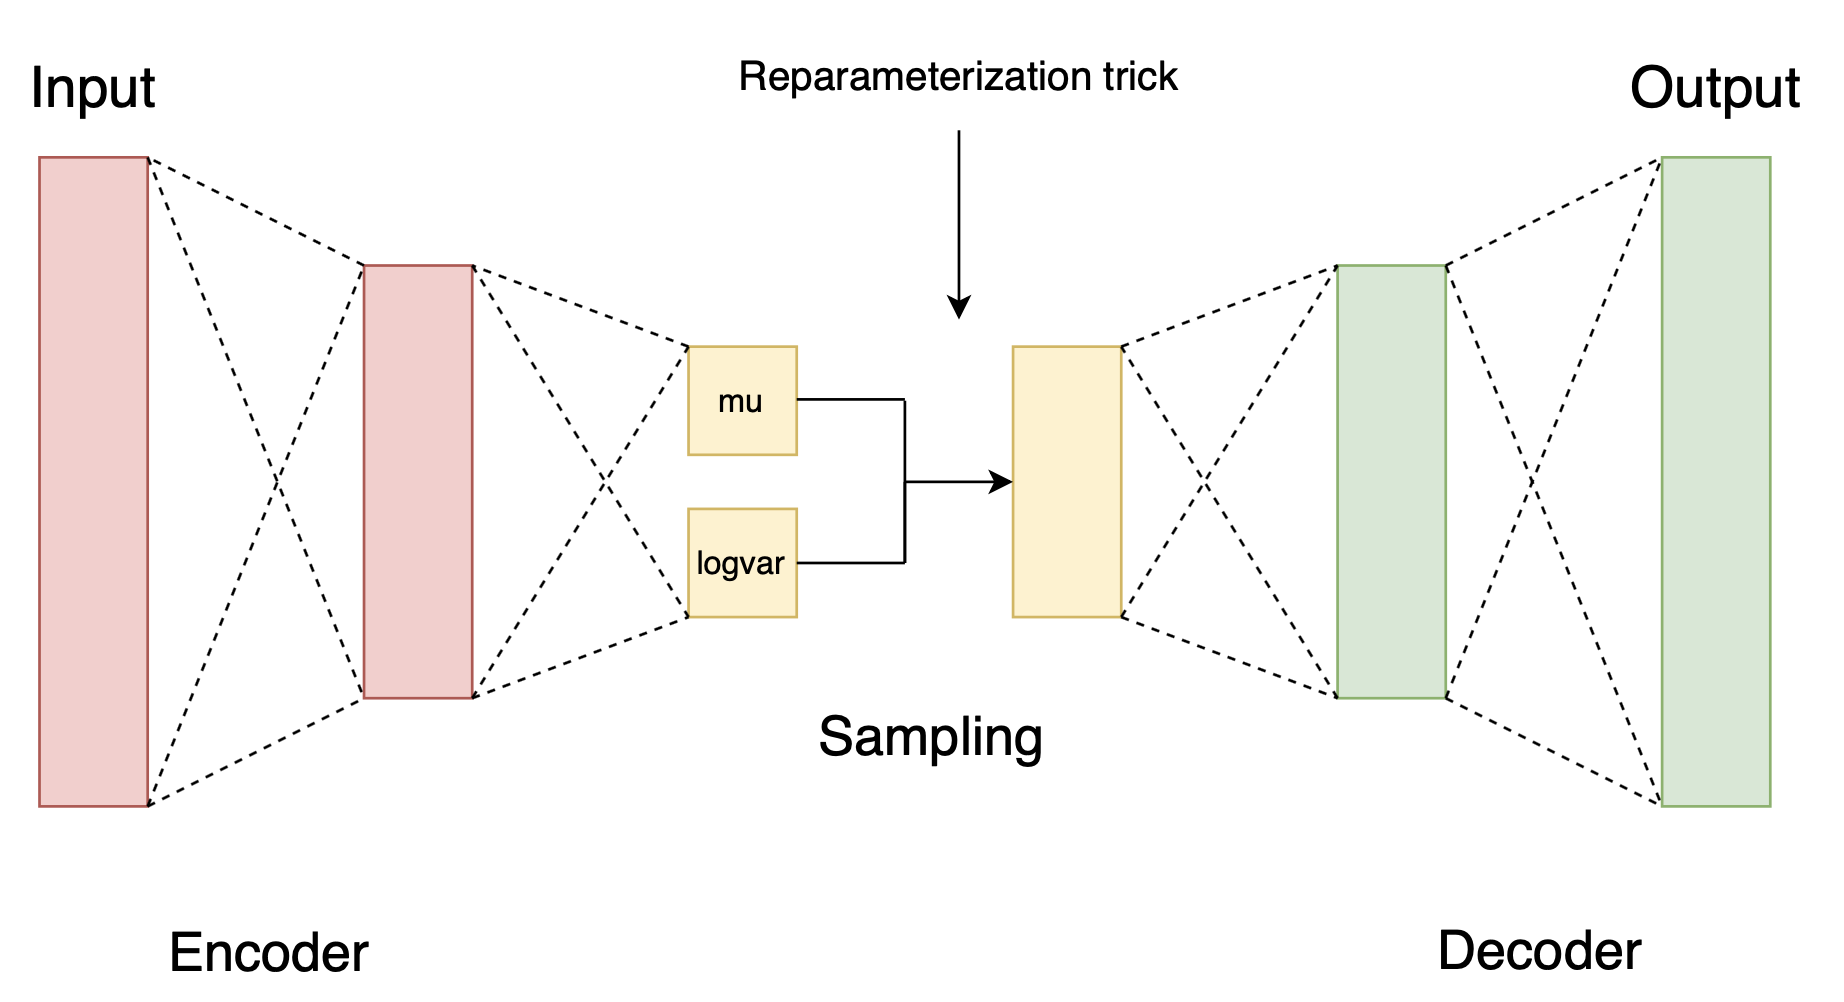

**TASK 1: Implement a VAE with the following network architecture**

We will implement a basic convolutional VAE architecture. Look at the following VAE class specification and implement it accordingly: 

**Encoder (sequential model):**
 * Convolutional Layer with (1, capacity) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1
 * ReLU Activation Layer
 * Convolutional Layer with (capacity, 2 * capacity) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1
 * ReLU Activation Layer
 
**Sampling:**
* mu, logvar: Linear Layer with 2 * capacity * 7 * 7 input features and latent_dims output features each 
* z: Linear Layer with latent_dims input features and 2 * capacity * 7 * 7 output features

**Decoder (sequential model):**
 * ConvTranspose2d Layer with (2 * capacity, capacity) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1 
 * ReLU Activation Layer
 * ConvTranspose2d Layer with (capacity, 1) number of (in, out)-channels, kernel size of 4 * 4, stride of 2 and padding of 1 
 * Sigmoid Activation Layer



**Hint**

For the sampling use the reparameterization trick:

To generate x ~ N(μ, σ²), sample ε ~ N(0, 1). Then x can be computed as x = μ + σε.

Further, remember to differentiate between training and eval: sample in training and return mu in eval.

**TODO** What does the trick do and why do we need it?

**YOUR ANSWER** 
It ensures that the sampling operation is differentiable, allowing for efficient learning of the model parameters through backpropagation. After the bottleneck follows a sampling operation (take sample from latent space distribution and feed that to Decoder) => no backpropagation possible after sampling => Reparametrization trick

In [312]:
# TODO Implement the VAE
class VAE(nn.Module):
    def __init__(self, capacity, latent_dims):
        super(VAE, self).__init__()

        # Encoder
        self.Encoder = nn.Sequential(
            nn.Conv2d(1, capacity, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(capacity, 2 * capacity, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        # Sampling layers
        self.fc_mu = nn.Linear(2 * capacity * 7 * 7, latent_dims)
        self.fc_logvar = nn.Linear(2 * capacity * 7 * 7, latent_dims)
        self.fc_z = nn.Linear(latent_dims, 2 * capacity * 7 * 7)

        # Decoder
        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(2 * capacity, capacity, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(capacity, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

        self.capacity = capacity
        self.latent_dims = latent_dims

    def encode(self, x):
        x = self.Encoder(x)
        h = torch.flatten(x, start_dim =1)
        mu = self.fc_mu(h)
        log_var = self.fc_logvar(h)
        
        sigma = torch.sqrt(torch.exp(log_var))
        
        epsilon = torch.normal(0, 1, size=mu.shape).to(device)
        z = (mu + sigma*epsilon) # reparametrization
        
        return z
    

    def decode(self, z):
        shape = (z.shape[0],64, 7, 7)
        z = self.fc_z(z).reshape(shape) 
        out = self.Decoder(z)
        
        return out

    def forward(self, x):
        
        x = self.Encoder(x)
        shape = x.shape

        x = torch.flatten(x, start_dim = 1)
        
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        sigma = torch.sqrt(torch.exp(log_var))

        epsilon = torch.normal(0, 1, size=mu.shape).to(device)
        z = (mu + sigma*epsilon)
        x = self.fc_z(z).reshape(shape) 
        
        #decoder
        out = self.Decoder(x)
        return out,mu,log_var

### Implement the loss function

Implement the two parts of the loss function: reconstruction loss using Mean Squared Error (MSE) function and the regularization part of the loss using Kullback-Leibler-Divergence (KLD).

**Hint:** 
- Make sure that you use sum instead of mean for calculating the MSE loss!
- Refer to the paper _Auto-Encoding Variational Bayes_ by Kingma and Welling to implement the loss function. 

In [313]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction losses are calculated using Mean Squared Error (MSE) and 
    # summed over all elements and batch
    mse_loss = nn.MSELoss()
    mse_loss = mse_loss(recon_x,x).sum()

    # See Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    kld_loss = 0.5 * torch.sum(1 + logvar - mu**2 - torch.exp(logvar)) * -1

    total_loss = mse_loss + kld_loss

    return total_loss, mse_loss, kld_loss

### Instantiate the model and define the optimizer to use.

In [314]:
model = VAE(capacity,latent_space_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss = vae_loss

In [315]:
model

VAE(
  (Encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=3136, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=3136, out_features=10, bias=True)
  (fc_z): Linear(in_features=10, out_features=3136, bias=True)
  (Decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Sigmoid()
  )
)

## Train the network

**TASK 2: Train the model and plot train+test set loss over training in the same plot**


In [316]:
import tqdm
import time
import fastprogress

In [317]:
def train(epoch, model, train_loader, optimizer, device, log_interval, detailed = True):
    model.train()
    train_loss = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        recon_data, mu, logvar = model(data)
        total_loss, mse_loss, kld_loss= vae_loss(recon_data, data, mu, logvar)
        (mse_loss).backward()
        cur_loss = total_loss.item()
        train_loss += cur_loss
        optimizer.step()
        if detailed:
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    cur_loss / len(data)))

    avg_train_loss = train_loss / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, avg_train_loss))
    return avg_train_loss

In [318]:
def test(epoch, model, test_loader, device, batch_size):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data = data.to(device)
            recon_data, mu, logvar = model(data)
            total_loss, mse_loss, kld_loss = vae_loss(recon_data, data, mu, logvar)
            cur_loss = total_loss.item()
            test_loss += cur_loss
            if batch_idx == 0:
                num_samples = min(batch_size, 8)
                comparison = torch.cat([data[:num_samples], recon_data.view(batch_size, 1, 28, 28)[:num_samples]]).cpu()
                save_generated_img(comparison, 'reconstruction', epoch, num_samples)

    avg_test_loss = test_loss / len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(avg_test_loss))
    return avg_test_loss

In [319]:
def sample_from_model(epoch):
    with torch.no_grad():
        # p(z) = N(0,I), this distribution is used when calculating KLD. So we can sample z from N(0,I)
        sample = torch.randn(64, latent_space_dim).to(device)
        sample = model.decode(sample).cpu().view(64, 1, 28, 28)
        save_generated_img(sample, 'sample', epoch)



In [320]:
def loss_plot(train_loss, test_loss):
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(test_loss, color='red', label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [321]:
def save_generated_img(image, name, epoch, nrow=8):
    if not os.path.exists('results'):
        os.makedirs('results')

    if epoch % 5 == 0:
        save_path = 'results/'+name+'_'+str(epoch)+'.png'
        save_image(image, save_path, nrow=nrow)

In [322]:
import os

train_losses = []
test_losses = []

for epoch in range(1, epochs + 1):
    train_loss = train(epoch, model, train_loader, optimizer, device, log_interval)
    test_loss = test(epoch, model, test_loader, device, batch_size)
    sample_from_model(epoch)

    train_losses.append(train_loss)
    test_losses.append(test_loss)



Train Epoch: 1 [0/60000 (0%)]	Loss: 0.031646
Train Epoch: 1 [12800/60000 (21%)]	Loss: 259.762268
Train Epoch: 1 [25600/60000 (43%)]	Loss: 225.395630
Train Epoch: 1 [38400/60000 (64%)]	Loss: 234.263168
Train Epoch: 1 [51200/60000 (85%)]	Loss: 226.355942
====> Epoch: 1 Average loss: 236.9010
====> Test set loss: 225.2364
Train Epoch: 2 [0/60000 (0%)]	Loss: 221.118454
Train Epoch: 2 [12800/60000 (21%)]	Loss: 223.262573
Train Epoch: 2 [25600/60000 (43%)]	Loss: 218.907654
Train Epoch: 2 [38400/60000 (64%)]	Loss: 219.612808
Train Epoch: 2 [51200/60000 (85%)]	Loss: 212.099228
====> Epoch: 2 Average loss: 220.4984
====> Test set loss: 204.5555
Train Epoch: 3 [0/60000 (0%)]	Loss: 210.854706
Train Epoch: 3 [12800/60000 (21%)]	Loss: 198.889923
Train Epoch: 3 [25600/60000 (43%)]	Loss: 204.854736
Train Epoch: 3 [38400/60000 (64%)]	Loss: 201.505325
Train Epoch: 3 [51200/60000 (85%)]	Loss: 192.665359
====> Epoch: 3 Average loss: 203.1950
====> Test set loss: 197.7707
Train Epoch: 4 [0/60000 (0%)]	Los

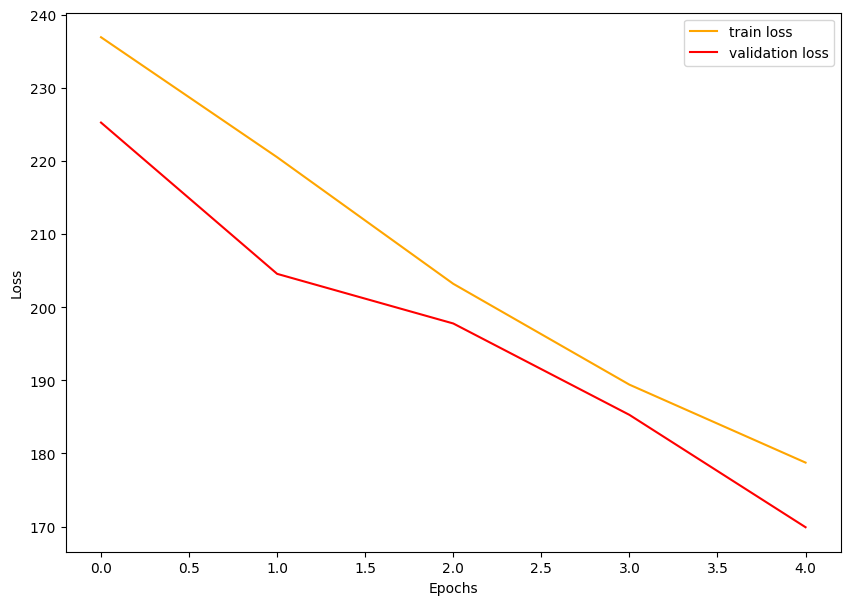

In [323]:
loss_plot(train_losses, test_losses)

### Visualization of random samples from the latent space via decoding

Here we just create a number of random samples from the latent space and use the decoder to generate images from them. Rerun the code cell to generate new samples every time!

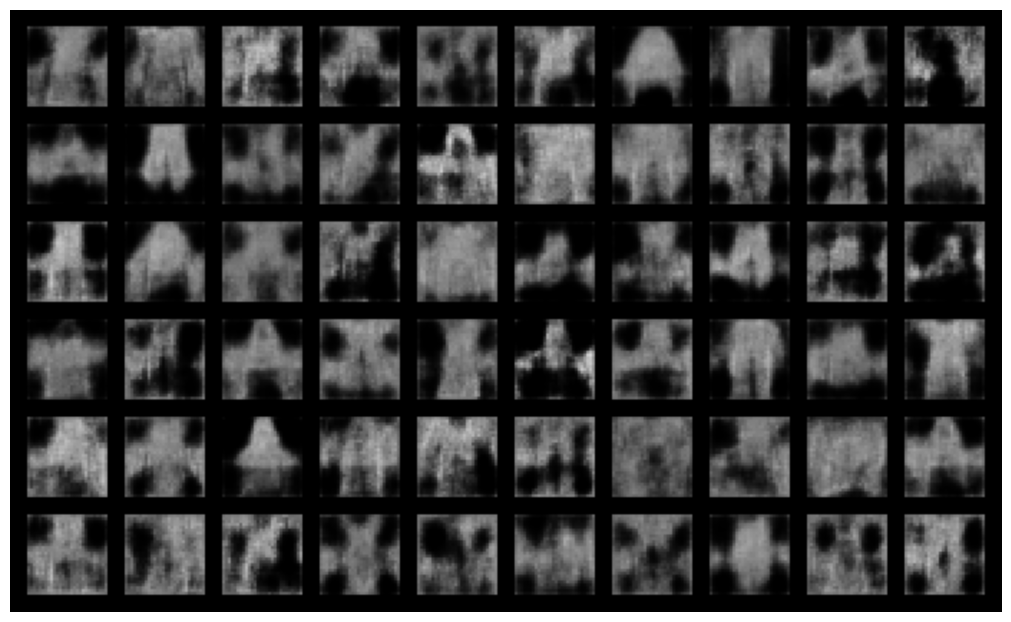

In [324]:
with torch.no_grad():
    samples = torch.randn(images_columns * images_rows, latent_space_dim).to(device)
    samples = model.decode(samples).cpu()

    show_grid(samples[0:(images_columns * images_rows)], images_columns, images_rows)

### Visualization of image reconstructions

Visualize the image reconstruction process and compare the reconstructions to the original images.

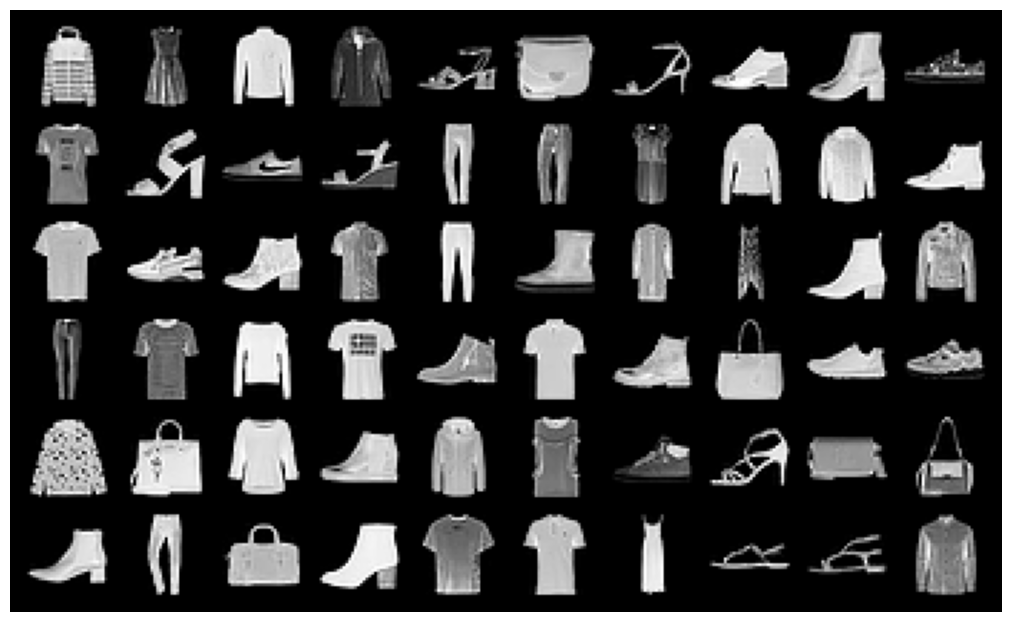

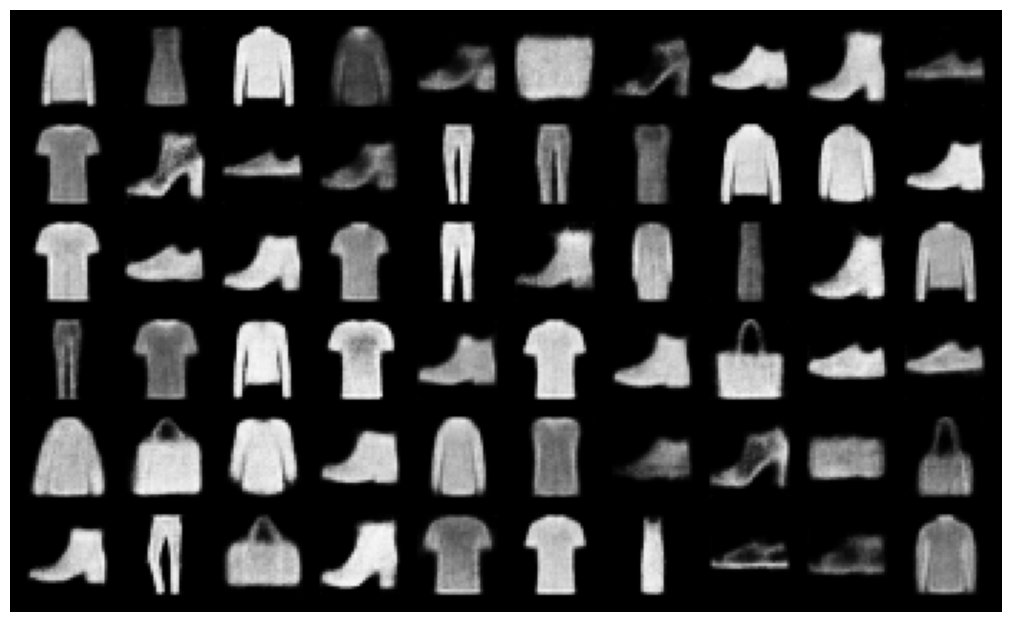

In [325]:
images_columns = 10
images_rows    = 6

data_iterator = iter(train_loader)
images, labels = next(data_iterator)

# Show original images
show_grid(images[0:(images_columns * images_rows)], images_columns, images_rows)

# Show reconstructed images
model.eval()
with torch.no_grad():

    # TODO: compute reconstruction
    images_recon,mean,logvar = model(images.to(device))

    show_grid(images_recon[0:(images_columns * images_rows)].cpu(), images_columns, images_rows)

### Optimization

**TASK 3: Explore dimensionality of latent space**

How does the dimensionality of latent space (set to 10 by default in our case) affect loss and quality of the reconstructions? Explore smaller and larger latent dimensionality by using 2, 4, 8, 16, 32 dimensions and looking at reconstructions and resulting test set losses. 

Latent Dimensions: 2
====> Epoch: 1 Average loss: 59.1867
====> Test set loss: 52.8107
====> Epoch: 2 Average loss: 49.3250
====> Test set loss: 43.9817
====> Epoch: 3 Average loss: 40.4303
====> Test set loss: 37.0043
====> Epoch: 4 Average loss: 35.4072
====> Test set loss: 31.9563
====> Epoch: 5 Average loss: 32.1385
====> Test set loss: 31.3135

Latent Dimensions: 4
====> Epoch: 1 Average loss: 132.2387
====> Test set loss: 130.5488
====> Epoch: 2 Average loss: 114.9996
====> Test set loss: 104.7815
====> Epoch: 3 Average loss: 100.6090
====> Test set loss: 95.6756
====> Epoch: 4 Average loss: 90.5610
====> Test set loss: 85.6717
====> Epoch: 5 Average loss: 82.2505
====> Test set loss: 77.6409

Latent Dimensions: 8
====> Epoch: 1 Average loss: 161.2079
====> Test set loss: 180.8240
====> Epoch: 2 Average loss: 179.9262
====> Test set loss: 173.8639
====> Epoch: 3 Average loss: 164.7298
====> Test set loss: 156.7478
====> Epoch: 4 Average loss: 150.3745
====> Test set loss: 144.505

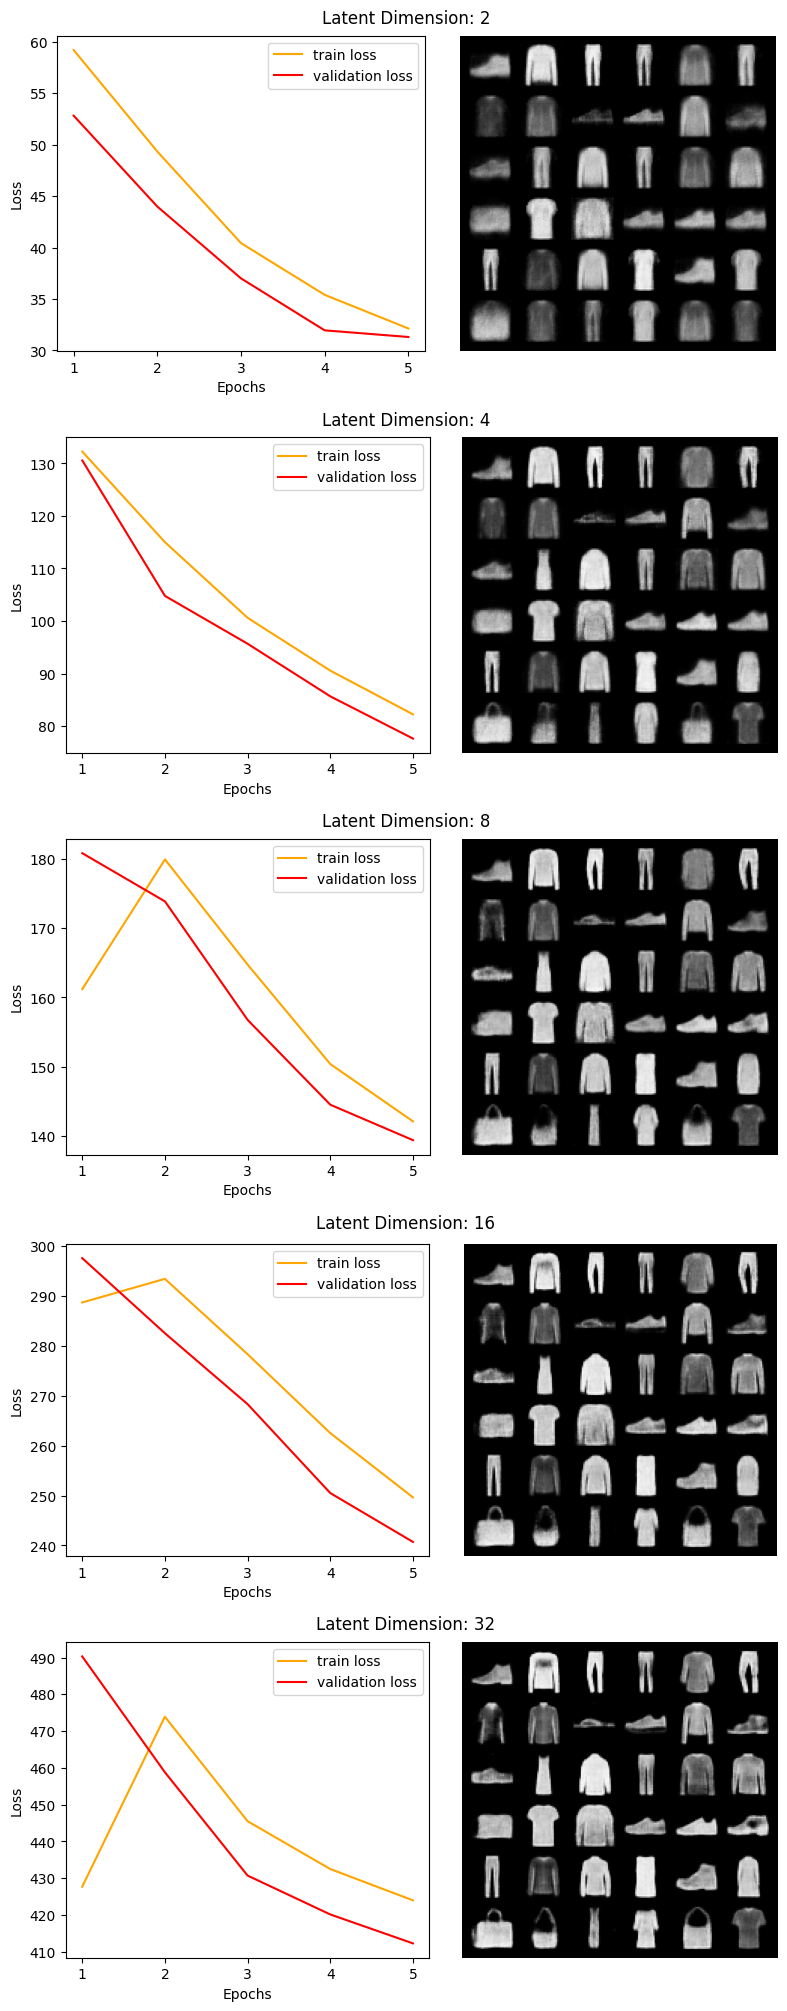

In [344]:
# TODO
images_columns = 6
images_rows    = 6
epoch_list = list(range(1, epochs + 1))
latent_dimensions = [2, 4, 8, 16, 32]

fig = plt.figure(constrained_layout=True, figsize=(8, 20))

subfigs = fig.subfigures(nrows=len(latent_dimensions), ncols=1)

for i, latent_dim in enumerate(latent_dimensions):
    
    subfigs[i].suptitle(f'Latent Dimension: {latent_dim}')
    axs = subfigs[i].subplots(nrows=1, ncols=2)
    
    print(f'Latent Dimensions: {latent_dim}')

    model = VAE(capacity=32, latent_dims=latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    train_losses = []
    test_losses = []

    for epoch in range(1, epochs + 1):
        train_loss = train(epoch, model, train_loader, optimizer, device, log_interval, detailed = False)
        test_loss = test(epoch, model, test_loader, device, batch_size)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
    
    axs[0].plot(epoch_list, train_losses, color='orange', label='train loss')
    axs[0].plot(epoch_list, test_losses, color='red', label='validation loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    model.eval()
    
    with torch.no_grad():
        data_iterator = iter(test_loader)
        test_images, _ = next(data_iterator)
        test_images = test_images.to(device)

        z = model.encode(test_images)
        recon_images = model.decode(z)
        
        recon_images = recon_images.view(recon_images.size(0), 1, 28, 28)

        test_images = test_images.cpu()
        recon_images = recon_images.cpu()

        test_images = test_images.clamp(0, 1)
        recon_images = recon_images.clamp(0, 1)
     
        image = torchvision.utils.make_grid(recon_images[0:(images_columns * images_rows)], images_columns, images_rows)
        image = image.numpy()
        
        axs[1].axis('off')
        axs[1].imshow(np.transpose(image, (1, 2, 0)))

        print("")

plt.show()

## Visualization of latent traversals

**TASK 4: Plot some latent traversals**

Latent traversal is a popular approach to visualize the disentangled latent representations. Given a bunch of variations in a single unit of the latent representation, it is expected that there is a change in a single factor of variation of the data while others are fixed. (See paper [Learning Disentangled Representations with Latent Variation Predictability](https://arxiv.org/abs/2007.12885))

Remember in the previous task you trained models with different latent dimensions. Each shape is encoded into a `latent_dim`-sized vector. In this task we want to see which shapes are reconstructed if we create a latent code (with latent_dimensions = 32) where we set 

- one of these dimensions (e.g. dim1=11) to different values ($x_i \in [-3,3]$)
- two of these dimensions (e.g. dim1=31, dim2=4) to different values ($x_i, x_j \in [-3,3]$)

while setting all other values of the latent code to $0$. Use the decoder of the VAE neural network to create images from these latent codes.

**TODO** Create a 1 x 10 array plot for the first visualization and a 10 x 10 matrix plot for the second showing latent space travels.

**TODO** Repeat the experiment, now setting the other dimensions of the vector to a random value in [-1,1] instead of zero. Write down what you observe.

Here are two examples.

1x10 traversal of one latent dimension

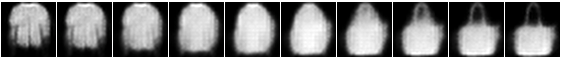

10x10 traversal of two latent dimensions

![10x10 traversal of two latent dimensions](https://i.imgur.com/hZXIYzv.png)

In [340]:
print(np.linspace(-3,3,num=10))

[-3.         -2.33333333 -1.66666667 -1.         -0.33333333  0.33333333
  1.          1.66666667  2.33333333  3.        ]


In [341]:
samples = torch.zeros(1*10, 32).to(device)
samples[:,11] = torch.from_numpy(np.linspace(-3,3,num=10))
print(samples)

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000, -3.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000, -2.3333,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000, -1.6667,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000

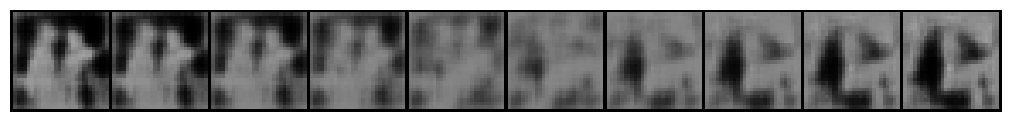

In [347]:
# TODO
images_rows = 1
images_columns = 10
dim = 11
latent_dim = 32

with torch.no_grad():
    samples = torch.zeros(images_rows*images_colums, latent_dim).to(device)
    samples[:,dim] = torch.from_numpy(np.linspace(-3,3,num=10))
    samples = model.decode(samples).cpu()
    show_grid(samples[0:(images_columns * images_rows)], images_columns, images_rows)



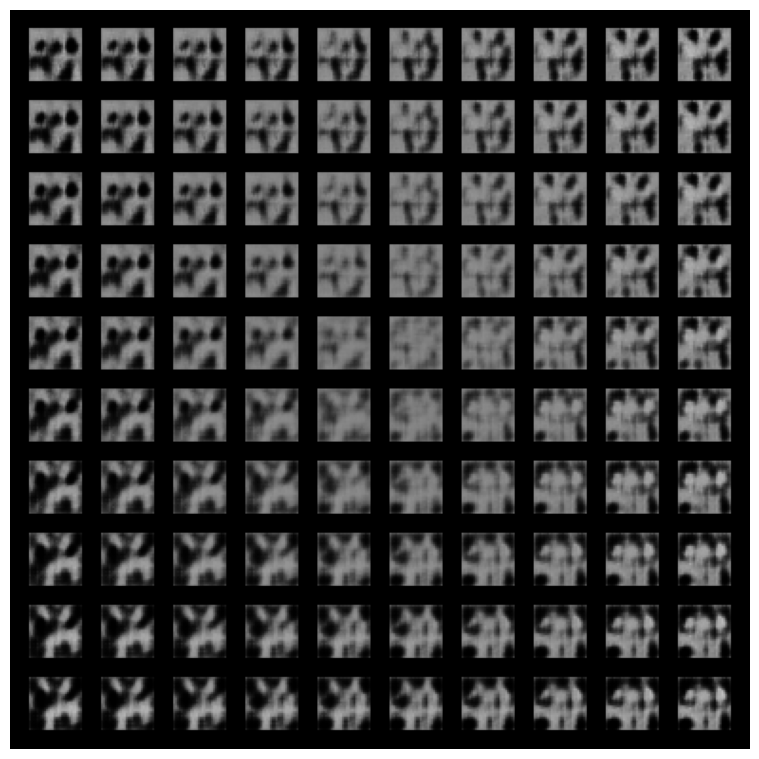

In [348]:
images_rows = 10
images_columns = 10
dim1 = 31
dim2 = 4
latent_dim = 32

samples = torch.zeros((images_rows*images_colums, latent_dim))
dim = torch.from_numpy(np.linspace(-3,3,num=10))

for j in range(10):
    for i in range(10):
        samples[10*j+i,dim1] = dim[j]
        samples[10*j+i,dim2] = dim[i]
    

with torch.no_grad():
    samples = (samples).to(device)
    samples = model.decode(samples).cpu()
    show_grid(samples[0:(images_columns * images_rows)], images_columns, images_rows)

### Visualize class labels in latent space

**TASK 5: Visualize class labels in latent space**

First create a new VAE-model with a 2d latent space on the full training data set. Then project all the images of the training set into the 2d latent space keeping track of their class labels. Use a 2d scatter plot to visualize the resulting latent space vectors and different colors for their labels. 

- Do images of the same class cluster in latent space?
- Do the data points in latent space look like a normal distribution?

**Your answer here**
- Yes, they do.
- No. They are skewed.

#### Train 2d latent space model

In [356]:
model = VAE(capacity,2).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss = vae_loss
train(epochs,model,train_loader,optimizer,device,log_interval)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.003431
Train Epoch: 5 [12800/60000 (21%)]	Loss: 106.578705
Train Epoch: 5 [25600/60000 (43%)]	Loss: 117.069420
Train Epoch: 5 [38400/60000 (64%)]	Loss: 89.546196
Train Epoch: 5 [51200/60000 (85%)]	Loss: 88.800804
====> Epoch: 5 Average loss: 86.5767


86.57669219086368

#### Visualize classes

In [359]:
def plot_2d_latent_space(z,labels):
    
    my_dict = {}
    my_dict[0] = 'Tshirt'
    my_dict[1] = 'trousers'
    my_dict[2] = 'pullover'
    my_dict[3] = 'dress'
    my_dict[4] = 'coat'
    my_dict[5] = 'sandal'
    my_dict[6] = 'shirt'
    my_dict[7] = 'sneaker'
    my_dict[8] = 'bag'
    my_dict[9] = 'mydic'
    
    #z = z.cpu().detach().numpy()
    #labels = labels.cpu().detach().numpy()
    
    for i in range(10):
        a = z[labels == i]
        
        plt.scatter(a[:,0], a[:,1],label = my_dict[i])
    #print(labels[i])
    
    plt.title('Latent Space')
    plt.legend(loc='upper center', bbox_to_anchor=(2, 1.05),
          ncol=3, fancybox=True, shadow=True)
    
    plt.figure(figsize=(10,10))
    plt.show()
    

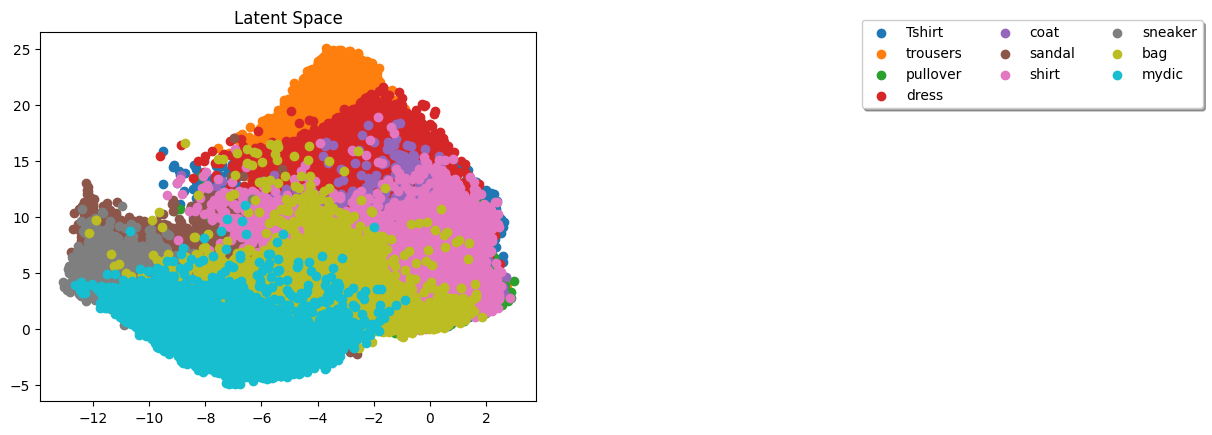

<Figure size 1000x1000 with 0 Axes>

In [360]:
loader = torch.utils.data.DataLoader(train_dataset, batch_size= len(train_loader.dataset), shuffle=True)

def project_to_latent_space(model, data_loader):
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(loader):
            data = data.to(device)
            z = model.encode(data)
            latent_vectors.append(z.cpu().numpy())
            labels.append(label.numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)

    return latent_vectors, labels

# Project training set images into 2D latent space
train_latent_vectors, train_labels = project_to_latent_space(model, loader)


#images,labels = next(iter(train_loader)
plot_2d_latent_space(train_latent_vectors, train_labels)



Each point in the scatter plot represents a data point in the latent space, and the color of the point is determined by the class it belongs to (as specified by the labels). The legend in your plot shows the corresponding classes for each color.

# Appendix [OPTIONAL]


Use standard MNIST or CIFAR-10 instead of fashion MNIST.

In [332]:
#transform = transforms.Compose([ 
#               transforms.Resize(image_size),
#                transforms.ToTensor(),
#               transforms.Normalize((0.1307,), (0.3081,))
#           ])

#train_dataset = datasets.MNIST(data_dir, train=True, download=True, transform=transform)
#test_dataset  = datasets.MNIST(data_dir, train=False, transform=transforms.ToTensor())